In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset

%load_ext autoreload
%autoreload 2

class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 6 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [4]:
from utils.functions import *
import math

N = args.num_users
K = args.num_partition
T = 2
sigma = 1
Noise_Alloc = [0,2] # np.random.choice(range(K+T), T, replace=False)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
# print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
print("alpha_array: ",alpha_array,'\n')

i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
print("z_array: ",z_array,'\n')

X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

alpha_array:  [ 0.98078528  0.83146961  0.55557023  0.19509032 -0.19509032 -0.55557023
 -0.83146961 -0.98078528] 

z_array:  [ 1.          0.9781476   0.91354546  0.80901699  0.66913061  0.5
  0.30901699  0.10452846 -0.10452846 -0.30901699 -0.5        -0.66913061
 -0.80901699 -0.91354546 -0.9781476 ] 

@BACC_Enc: N,K,T, m_i= 15 6 2 10000 

@BACC_Enc: N,K,T, m_i= 15 6 2 10000 



In [34]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

# training
loss_train_arr = []
loss_test_arr = []
acc_test_arr = []
net_best = None
best_loss = None

N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
m_array = np.array([15]) # m is the number of received result @ master

T_array = np.array([0,1,2,3,4,5,6,7]) # m is the number of received result @ master

loss_test_arr = np.empty((len(T_array),N_trials,N_epochs))
acc_test_arr  = np.empty((len(T_array),N_trials,N_epochs))

for T_idx in range(len(T_array)):
    
    m = N # m is the number of received result @ master
    
    T = T_array[T_idx]
    
    if T == 0:
        Noise_Alloc = []
    elif T == 1:
        Noise_Alloc = [0]
    elif T == 2:
        Noise_Alloc = [0,2]
    elif T == 3:
        Noise_Alloc = [0,2,4]
    elif T == 4:
        Noise_Alloc = [1,3,5,7]
    elif T == 5:
        Noise_Alloc = [1,3,5,7,9]
    elif T == 6:
        Noise_Alloc = [1,3,5,7,9,11]
    elif T == 7:
        Noise_Alloc = [1,3,5,7,9,11,12] # np.random.choice(range(K+T), T, replace=False)
    else:
        Noise_Alloc = np.random.choice(range(K+T), T, replace=False)
        
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)
            
    j_array = np.array(range(K+T))
    # print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
    
    X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
    y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
    
    for trial_idx in range(N_trials):
        print('(T=',T,') ',trial_idx,'-th Trial!!')
        
        net_glob = CNNMnist2(args=args)
        net_glob.cuda()
        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()

        for iter in range(N_epochs): #args.epochs
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)
            
            coded_net = BACC_Enc_Model_withNoise(net_glob.cuda(), N, K, T, 0.01, _Noise_Alloc=Noise_Alloc)
            
            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
        #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

        #     loss_train_arr.append(loss_train)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[T_idx][trial_idx][iter] = acc_test
            loss_test_arr[T_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
            #print(loss_train)

@BACC_Enc: N,K,T, m_i= 15 6 0 10000 

@BACC_Enc: N,K,T, m_i= 15 6 0 10000 

(T= 0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1475 
Accuracy: 8582/10000 (85.82%)

Round   1, Average loss 2.148 Test accuracy 85.820
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2876 
Accuracy: 9448/10000 (94.48%)

Round   2, Average loss 0.288 Test accuracy 94.480
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1843 
Accuracy: 9487/10000 (94.87%)

Round   3, Average loss 0.184 Test accuracy 94.870
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1433 
Accuracy: 9566/10000 (95.66%)

Round   4, Average loss 0.143 Test accuracy 95.660
selected users


Test set: Average loss: 0.1889 
Accuracy: 9551/10000 (95.51%)

Round  15, Average loss 0.189 Test accuracy 95.510
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1938 
Accuracy: 9499/10000 (94.99%)

Round  16, Average loss 0.194 Test accuracy 94.990
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2187 
Accuracy: 9565/10000 (95.65%)

Round  17, Average loss 0.219 Test accuracy 95.650
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2136 
Accuracy: 9558/10000 (95.58%)

Round  18, Average loss 0.214 Test accuracy 95.580
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2275 
Accuracy: 9509/10000 (95.09%)

Round  19, Average loss 0.228 Test accuracy 95.090
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2251 
Accuracy: 9527/10000 (95.27%)

Round  20, Average loss 0.225 Test accuracy 95


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.7625 
Accuracy: 7450/10000 (74.50%)

Round   1, Average loss 1.762 Test accuracy 74.500
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4425 
Accuracy: 9098/10000 (90.98%)

Round   2, Average loss 0.443 Test accuracy 90.980
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.7464 
Accuracy: 9118/10000 (91.18%)

Round   3, Average loss 0.746 Test accuracy 91.180
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.9830 
Accuracy: 8996/10000 (89.96%)

Round   4, Average loss 0.983 Test accuracy 89.960
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.9814 
Accuracy: 9089/10000 (90.89%)

Round   5, Average loss 0.981 Test accuracy 90.89


Test set: Average loss: 0.4937 
Accuracy: 9062/10000 (90.62%)

Round  16, Average loss 0.494 Test accuracy 90.620
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4988 
Accuracy: 8907/10000 (89.07%)

Round  17, Average loss 0.499 Test accuracy 89.070
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5103 
Accuracy: 8918/10000 (89.18%)

Round  18, Average loss 0.510 Test accuracy 89.180
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5296 
Accuracy: 8808/10000 (88.08%)

Round  19, Average loss 0.530 Test accuracy 88.080
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5251 
Accuracy: 9050/10000 (90.50%)

Round  20, Average loss 0.525 Test accuracy 90.500
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5342 
Accuracy: 8820/10000 (88.20%)

Round  21, Average loss 0.534 Test accuracy 88


Test set: Average loss: 2.2951 
Accuracy: 3792/10000 (37.92%)

Round   1, Average loss 2.295 Test accuracy 37.920
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.5923 
Accuracy: 8987/10000 (89.87%)

Round   2, Average loss 1.592 Test accuracy 89.870
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.8873 
Accuracy: 9215/10000 (92.15%)

Round   3, Average loss 0.887 Test accuracy 92.150
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6105 
Accuracy: 9273/10000 (92.73%)

Round   4, Average loss 0.610 Test accuracy 92.730
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5313 
Accuracy: 9339/10000 (93.39%)

Round   5, Average loss 0.531 Test accuracy 93.390
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5639 
Accuracy: 9346/10000 (93.46%)

Round   6, Average loss 0.564 Test accuracy 93


Test set: Average loss: 0.2488 
Accuracy: 9365/10000 (93.65%)

Round  17, Average loss 0.249 Test accuracy 93.650
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2228 
Accuracy: 9381/10000 (93.81%)

Round  18, Average loss 0.223 Test accuracy 93.810
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2247 
Accuracy: 9361/10000 (93.61%)

Round  19, Average loss 0.225 Test accuracy 93.610
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2157 
Accuracy: 9362/10000 (93.62%)

Round  20, Average loss 0.216 Test accuracy 93.620
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2284 
Accuracy: 9391/10000 (93.91%)

Round  21, Average loss 0.228 Test accuracy 93.910
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2165 
Accuracy: 9411/10000 (94.11%)

Round  22, Average loss 0.217 Test accuracy 94

(8, 1, 30)


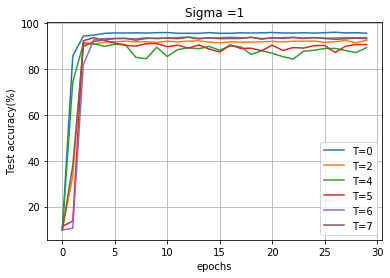

In [36]:
plot_acc = acc_test_arr
# print(acc_test_arr.shape)
print(plot_acc.shape)

sigma_sel = 0

title_name = 'Sigma ='+str(1)
plt.plot(plot_acc[0,sigma_sel,:],label='T=0')
# plt.plot(plot_acc[1,:],label='T=1')
plt.plot(plot_acc[2,sigma_sel,:],label='T=2')
plt.plot(plot_acc[3,sigma_sel,:],label='T=4')
plt.plot(plot_acc[4,sigma_sel,:],label='T=5')
plt.plot(plot_acc[5,sigma_sel,:],label='T=6')
plt.plot(plot_acc[6,sigma_sel,:],label='T=7')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [41]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

# training
loss_train_arr = []
loss_test_arr = []
acc_test_arr = []
net_best = None
best_loss = None

N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
m_array = np.array([15]) # m is the number of received result @ master

T_array = np.array([8,9,10,11]) # m is the number of received result @ master

loss_test_arr_v2 = np.empty((len(T_array),N_trials,N_epochs))
acc_test_arr_v2  = np.empty((len(T_array),N_trials,N_epochs))

for T_idx in range(len(T_array)):
    
    m = N # m is the number of received result @ master
    
    T = T_array[T_idx]
    
    if T == 0:
        Noise_Alloc = []
    elif T == 1:
        Noise_Alloc = [0]
    elif T == 2:
        Noise_Alloc = [0,2]
    elif T == 3:
        Noise_Alloc = [0,2,4]
    elif T == 4:
        Noise_Alloc = [1,3,5,7]
    elif T == 5:
        Noise_Alloc = [1,3,5,7,9]
    elif T == 6:
        Noise_Alloc = [1,3,5,7,9,11]
    elif T == 7:
        Noise_Alloc = [1,3,5,7,9,11,12] # np.random.choice(range(K+T), T, replace=False)
    elif T == 8:
        Noise_Alloc = [0,2,4,6,8,9,11,13] # np.random.choice(range(K+T), T, replace=False)
    elif T == 9:
        Noise_Alloc = [0,2,4,6,8,10,12,13,14] # np.random.choice(range(K+T), T, replace=False)
    elif T == 10:
        Noise_Alloc = [0,2,4,6,8,10,12,13,14,15] # np.random.choice(range(K+T), T, replace=False)
    elif T == 11:
        Noise_Alloc = [0,2,4,6,8,10,12,13,14,15,16] # np.random.choice(range(K+T), T, replace=False)
    else:
        Noise_Alloc = np.random.choice(range(K+T), T, replace=False)
        
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)
            
    j_array = np.array(range(K+T))
    # print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
    
    X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
    y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
    
    for trial_idx in range(N_trials):
        print('(T=',T,') ',trial_idx,'-th Trial!!')
        
        net_glob = CNNMnist2(args=args)
        net_glob.cuda()
        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()

        for iter in range(N_epochs): #args.epochs
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)
            
            coded_net = BACC_Enc_Model_withNoise(net_glob.cuda(), N, K, T, 0.01, _Noise_Alloc=Noise_Alloc)
            
            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
        #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

        #     loss_train_arr.append(loss_train)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_v2[T_idx][trial_idx][iter] = acc_test
            loss_test_arr_v2[T_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
            #print(loss_train)

@BACC_Enc: N,K,T, m_i= 15 6 8 10000 

@BACC_Enc: N,K,T, m_i= 15 6 8 10000 

(T= 8 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3018 
Accuracy: 1137/10000 (11.37%)

Round   1, Average loss 2.302 Test accuracy 11.370
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2938 
Accuracy: 1365/10000 (13.65%)

Round   2, Average loss 2.294 Test accuracy 13.650
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1826 
Accuracy: 8477/10000 (84.77%)

Round   3, Average loss 2.183 Test accuracy 84.770
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.0098 
Accuracy: 8560/10000 (85.60%)

Round   4, Average loss 2.010 Test accuracy 85.600
selected users


Test set: Average loss: 2.3025 
Accuracy: 1060/10000 (10.60%)

Round  15, Average loss 2.302 Test accuracy 10.600
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  16, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 551/10000 (5.51%)

Round  17, Average loss 2.303 Test accuracy 5.510
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  18, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  19, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 978/10000 (9.78%)

Round  20, Average loss 2.303 Test accuracy 9.780
selected u

KeyboardInterrupt: 

(8, 1, 30)


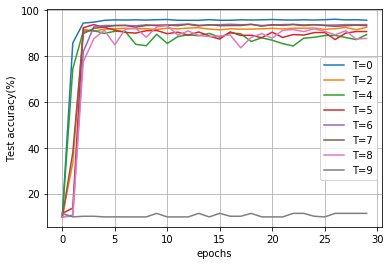

In [40]:
plot_acc_v2 = acc_test_arr_v2
# print(acc_test_arr.shape)
print(plot_acc.shape)

sigma_sel = 0

# title_name = 'Sigma ='+str(1)
plt.plot(plot_acc[0,sigma_sel,:],label='T=0')
# plt.plot(plot_acc[1,:],label='T=1')
plt.plot(plot_acc[2,sigma_sel,:],label='T=2')
plt.plot(plot_acc[3,sigma_sel,:],label='T=4')
plt.plot(plot_acc[4,sigma_sel,:],label='T=5')
plt.plot(plot_acc[5,sigma_sel,:],label='T=6')
plt.plot(plot_acc[6,sigma_sel,:],label='T=7')

plt.plot(plot_acc_v2[0,sigma_sel,:],label='T=8')
plt.plot(plot_acc_v2[1,sigma_sel,:],label='T=9')
# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 2. T=4, Difference Noise Allocation

In [10]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = args.num_users
K = args.num_partition




# training



N_trials = 1
N_epochs = 40

# m_array = np.array(range(4,16)) # m is the number of received result @ master
alloc_Num = 2
sigma_array = np.array([10])


loss_test_arr_v5 = np.zeros((alloc_Num,len(sigma_array),N_trials,N_epochs))
acc_test_arr_v5  = np.zeros((alloc_Num,len(sigma_array),N_trials,N_epochs))

for alloc_idx in range(alloc_Num):
    


    
    T = 4
    
    if alloc_idx == 0:
        Noise_Alloc = [1,3,6,8]
    elif alloc_idx == 1:
        Noise_Alloc = [0,3,6,9]
    elif alloc_idx == 2:
        Noise_Alloc = [1,3,5,8]
    elif alloc_idx == 3:
        Noise_Alloc = [0,1,2,3]
    elif alloc_idx == 4:
        Noise_Alloc = [0,1,5,9]
    elif alloc_idx == 5:
        Noise_Alloc = [0,2,4,6]
    else:
        Noise_Alloc = [6,7,8,9]
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)

    j_array = np.array(range(K+T))
    # print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
    
    for sigma_idx in range(len(sigma_array)):
        
        sigma = sigma_array[sigma_idx]
        
        _Noise_label = np.ones((10000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise(net_glob.cuda(), N, K, T, 0.01, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v5[alloc_idx][sigma_idx][trial_idx][iter] = acc_test
                loss_test_arr_v5[alloc_idx][sigma_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

(T, sigma)= 4 10 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2988 
Accuracy: 993/10000 (9.93%)

Round   2, Average loss 2.299 Test accuracy 9.930
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2639 
Accuracy: 6690/10000 (66.90%)

Round   3, Average loss 2.264 Test accuracy 66.900
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1645 
Accuracy: 8533/10000 (85.33%)

Round   4, Average loss 2.164 Test accuracy 85.330
selected 


Test set: Average loss: 2.3023 
Accuracy: 1135/10000 (11.35%)

Round   5, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3021 
Accuracy: 1135/10000 (11.35%)

Round   6, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2952 
Accuracy: 1827/10000 (18.27%)

Round   7, Average loss 2.295 Test accuracy 18.270
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2310 
Accuracy: 6551/10000 (65.51%)

Round   8, Average loss 2.231 Test accuracy 65.510
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1390 
Accuracy: 8492/10000 (84.92%)

Round   9, Average loss 2.139 Test accuracy 84.920
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.0664 
Accuracy: 8790/10000 (87.90%)

Round  10, Average loss 2.066 Test accuracy 87

(6, 1, 1, 30)


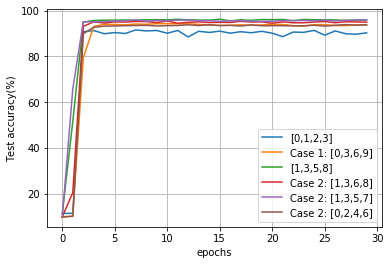

In [4]:
sigma_sel = 0

plot_acc_v3 = acc_test_arr_v3

print(plot_acc_v3.shape)

# if alloc_idx == 0:
#     Noise_Alloc = [0,1,2,3]
# elif alloc_idx == 1:
#     Noise_Alloc = [0,3,6,9]
# elif alloc_idx == 2:
#     Noise_Alloc = [1,3,5,8]
# elif alloc_idx == 3:
#     Noise_Alloc = [1,3,6,8]
# elif alloc_idx == 4:
#     Noise_Alloc = [1,3,5,7]
# elif alloc_idx == 5:
#     Noise_Alloc = [0,2,4,6]
# else:
#     Noise_Alloc = [6,7,8,9]

plt.plot(plot_acc_v3[0,sigma_sel,0,:],label='[0,1,2,3]')
plt.plot(plot_acc_v3[1,sigma_sel,0,:],label='Case 1: [0,3,6,9]')
plt.plot(plot_acc_v3[2,sigma_sel,0,:],label='[1,3,5,8]')
plt.plot(plot_acc_v3[3,sigma_sel,0,:],label='Case 2: [1,3,6,8]')
plt.plot(plot_acc_v3[4,sigma_sel,0,:],label='Case 2: [1,3,5,7]')
plt.plot(plot_acc_v3[5,sigma_sel,0,:],label='Case 2: [0,2,4,6]')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

(6, 1, 1, 30)


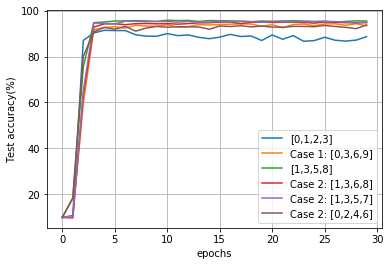

In [6]:
sigma_sel = 0

plot_acc_v4 = acc_test_arr_v4

print(plot_acc_v3.shape)

# if alloc_idx == 0:
#     Noise_Alloc = [0,1,2,3]
# elif alloc_idx == 1:
#     Noise_Alloc = [0,3,6,9]
# elif alloc_idx == 2:
#     Noise_Alloc = [1,3,5,8]
# elif alloc_idx == 3:
#     Noise_Alloc = [1,3,6,8]
# elif alloc_idx == 4:
#     Noise_Alloc = [1,3,5,7]
# elif alloc_idx == 5:
#     Noise_Alloc = [0,2,4,6]
# else:
#     Noise_Alloc = [6,7,8,9]

plt.plot(plot_acc_v4[0,sigma_sel,0,:],label='[0,1,2,3]')
plt.plot(plot_acc_v4[1,sigma_sel,0,:],label='Case 1: [0,3,6,9]')
plt.plot(plot_acc_v4[2,sigma_sel,0,:],label='[1,3,5,8]')
plt.plot(plot_acc_v4[3,sigma_sel,0,:],label='Case 2: [1,3,6,8]')
plt.plot(plot_acc_v4[4,sigma_sel,0,:],label='Case 2: [1,3,5,7]')
plt.plot(plot_acc_v4[5,sigma_sel,0,:],label='Case 2: [0,2,4,6]')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

(6, 1, 1, 30)


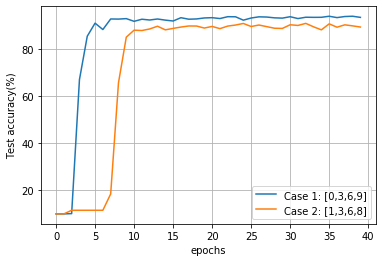

In [11]:
sigma_sel = 0

plot_acc_v5 = acc_test_arr_v5

print(plot_acc_v3.shape)

# if alloc_idx == 0:
#     Noise_Alloc = [0,1,2,3]
# elif alloc_idx == 1:
#     Noise_Alloc = [0,3,6,9]
# elif alloc_idx == 2:
#     Noise_Alloc = [1,3,5,8]
# elif alloc_idx == 3:
#     Noise_Alloc = [1,3,6,8]
# elif alloc_idx == 4:
#     Noise_Alloc = [1,3,5,7]
# elif alloc_idx == 5:
#     Noise_Alloc = [0,2,4,6]
# else:
#     Noise_Alloc = [6,7,8,9]

# plt.plot(plot_acc_v5[0,sigma_sel,0,:],label='[0,1,2,3]')
plt.plot(plot_acc_v5[0,sigma_sel,0,:],label='Case 1: [0,3,6,9]')
# plt.plot(plot_acc_v5[2,sigma_sel,0,:],label='[1,3,5,8]')
plt.plot(plot_acc_v5[1,sigma_sel,0,:],label='Case 2: [1,3,6,8]')
# plt.plot(plot_acc_v5[4,sigma_sel,0,:],label='Case 2: [1,3,5,7]')
# plt.plot(plot_acc_v5[5,sigma_sel,0,:],label='Case 2: [0,2,4,6]')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [48]:
from utils.functions import *
import math

N = 15
K = 6
T = 4
sigma = 1

Noise_Alloc = [0,3,6,9]

X_tilde_case1,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde_case1,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)





alpha_array:  [ 0.96592583  0.70710678  0.25881905 -0.25881905 -0.70710678 -0.96592583] 

z_array:  [ 1.          0.9781476   0.91354546  0.80901699  0.66913061  0.5
  0.30901699  0.10452846 -0.10452846 -0.30901699 -0.5        -0.66913061
 -0.80901699 -0.91354546 -0.9781476 ] 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 



In [49]:
N = 15
K = 6
T = 4
sigma = 1

Noise_Alloc = [1,3,6,8]


X_tilde_case2,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde_case2,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)


@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 



<Figure size 432x288 with 0 Axes>

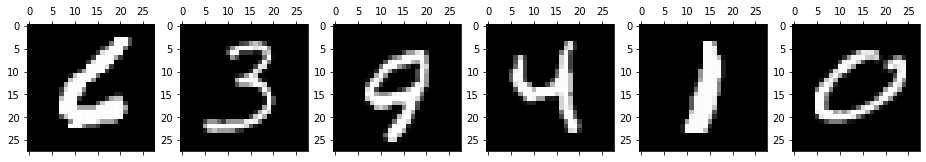

In [60]:
index_num = 3

index_sel = np.array(range(K))*Size_submatrices + index_num
# print(index_sel)

input_images = encoding_input_array_np[index_sel,:]
input_labels = encoding_label_array_np[index_sel,:]

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,K):
    ax = fig.add_subplot(1,6,i+1)
    pixels = input_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

# print("Input images & labels")
# for i in range(len(index_sel)):
#     print('label=',input_labels[i,:])
#     pixels = input_images[i,:].reshape((28, 28))
#     plt.imshow(pixels, cmap='gray')
#     plt.show()
# print("\n\n")

Encoded images & labels


<Figure size 432x288 with 0 Axes>

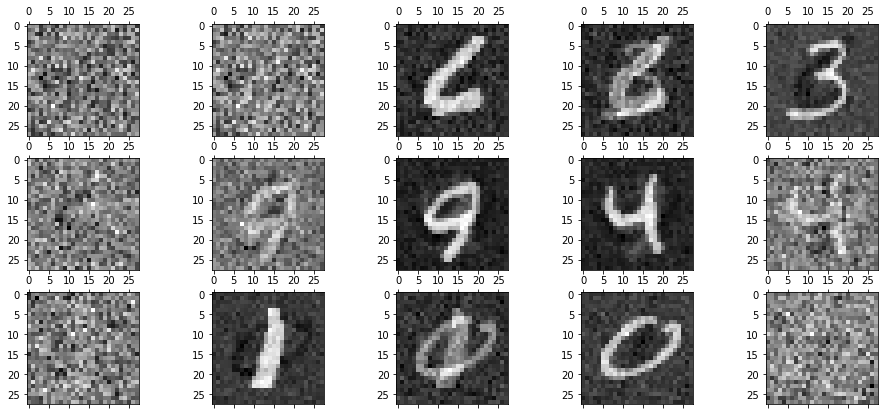

In [69]:
print("Encoded images & labels")
# print(X_tilde.shape)
# print(y_tilde.shape)
encoded_images = X_tilde_case1[:,index_num,:]
encoded_labels = y_tilde_case1[:,index_num,:]
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

# for i in range(encoded_images.shape[0]):
#     print('label=', encoded_labels[i,:])
#     pixels = encoded_images[i,:].reshape((28, 28))
#     plt.imshow(pixels, cmap='gray')
#     plt.show()

Encoded images & labels


<Figure size 432x288 with 0 Axes>

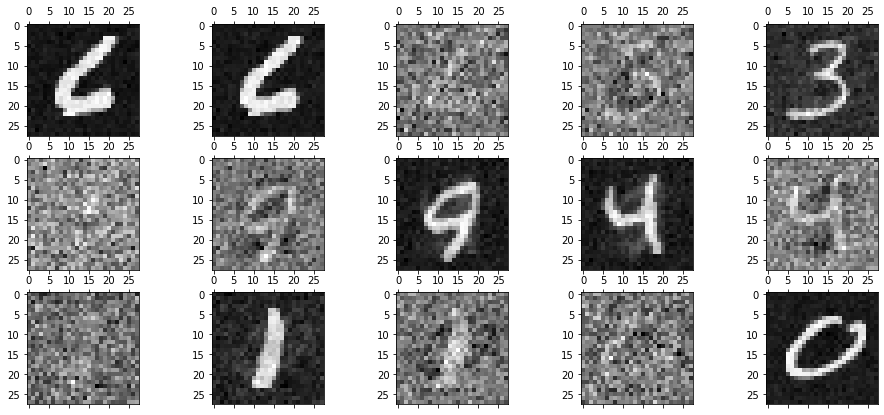

In [71]:
print("Encoded images & labels")
# print(X_tilde.shape)
# print(y_tilde.shape)
encoded_images = X_tilde_case2[:,index_num,:]
encoded_labels = y_tilde_case2[:,index_num,:]
# print(encoded_images.shape)
np.set_printoptions(precision=3)

# for i in range(encoded_images.shape[0]):
#     print('label=', encoded_labels[i,:])
#     pixels = encoded_images[i,:].reshape((28, 28))
#     plt.imshow(pixels, cmap='gray')
#     plt.show()

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

In [72]:
j_array = np.array(range(K+T))
print("j: ",(2*j_array+1)*math.pi/2/(K+T),'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
print("alpha_array: ",alpha_array,'\n')

i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
print("z_array: ",z_array,'\n')

j:  [0.262 0.785 1.309 1.833 2.356 2.88  3.403 3.927 4.451 4.974] 

alpha_array:  [ 0.988  0.891  0.707  0.454  0.156 -0.156 -0.454 -0.707 -0.891 -0.988] 

z_array:  [ 1.     0.978  0.914  0.809  0.669  0.5    0.309  0.105 -0.105 -0.309
 -0.5   -0.669 -0.809 -0.914 -0.978] 



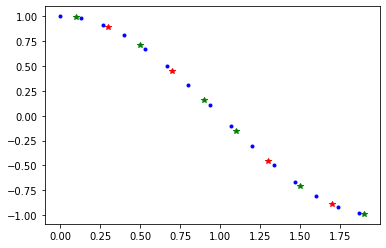

In [79]:
Noise_Alloc = [1,3,6,8]
Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

plt.plot(2*i_array/N,z_array,'b.')
plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='Noise')
plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='Signal')
plt.show()

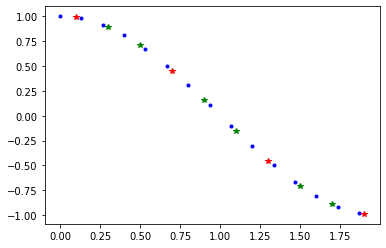

In [80]:
Noise_Alloc = [0,3,6,9]
Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

plt.plot(2*i_array/N,z_array,'b.')
plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='Noise')
plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='Signal')
plt.show()

# 3. Different Noise Variance

In [5]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

# training
loss_train_arr = []
loss_test_arr = []
acc_test_arr = []
net_best = None
best_loss = None

N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
T_array = np.array([2,4]) # m is the number of received result @ master

sigma_array = np.array([0.1, 1, 10])

loss_test_arr_v4 = np.empty((len(T_array),len(sigma_array),N_trials,N_epochs))
acc_test_arr_v4  = np.empty((len(T_array),len(sigma_array),N_trials,N_epochs))

for T_idx in range(len(T_array)):
    
    m = N # m is the number of received result @ master
    
    T = T_array[T_idx]
    
    if T == 0:
        Noise_Alloc = []
    elif T == 1:
        Noise_Alloc = [0]
    elif T == 2:
        Noise_Alloc = [0,2]
    elif T == 3:
        Noise_Alloc = [0,2,4]
    elif T == 4:
        Noise_Alloc = [1,3,5,7]
    elif T == 5:
        Noise_Alloc = [1,3,5,7,9]
    elif T == 6:
        Noise_Alloc = [1,3,5,7,9,11]
    elif T == 7:
        Noise_Alloc = [1,3,5,7,9,11,12] # np.random.choice(range(K+T), T, replace=False)
    elif T == 8:
        Noise_Alloc = [0,2,4,6,8,9,11,13] # np.random.choice(range(K+T), T, replace=False)
    elif T == 9:
        Noise_Alloc = [0,2,4,6,8,10,12,13,14] # np.random.choice(range(K+T), T, replace=False)
    elif T == 10:
        Noise_Alloc = [0,2,4,6,8,10,12,13,14,15] # np.random.choice(range(K+T), T, replace=False)
    elif T == 11:
        Noise_Alloc = [0,2,4,6,8,10,12,13,14,15,16] # np.random.choice(range(K+T), T, replace=False)
    else:
        Noise_Alloc = np.random.choice(range(K+T), T, replace=False)
        
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)
            
    j_array = np.array(range(K+T))
    # print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
    
    for sigma_idx in range(len(sigma_array)):
        
        sigma = sigma_array[sigma_idx]
    
        X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        for trial_idx in range(N_trials):
            print('(T,sigma=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)

                coded_net = BACC_Enc_Model_withNoise(net_glob.cuda(), N, K, T, 0.01, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v4[T_idx][sigma_idx][trial_idx][iter] = acc_test
                loss_test_arr_v4[T_idx][sigma_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

@BACC_Enc: N,K,T, m_i= 15 6 2 10000 

@BACC_Enc: N,K,T, m_i= 15 6 2 10000 

(T,sigma= 2 0.1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2985 
Accuracy: 1009/10000 (10.09%)

Round   0, Average loss 2.298 Test accuracy 10.090
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 3.9505 
Accuracy: 1315/10000 (13.15%)

Round   1, Average loss 3.950 Test accuracy 13.150
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.7289 
Accuracy: 5077/10000 (50.77%)

Round   2, Average loss 2.729 Test accuracy 50.770
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2970 
Accuracy: 7775/10000 (77.75%)

Round   3, Average loss 2.297 Test accuracy 77.750
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 10.4531 
Accuracy: 2852/10000 (28.52%)

Round   4, Average loss 10.453 Test accuracy 28.520


Test set: Average loss: 0.3533 
Accuracy: 9106/10000 (91.06%)

Round  15, Average loss 0.353 Test accuracy 91.060
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3557 
Accuracy: 9145/10000 (91.45%)

Round  16, Average loss 0.356 Test accuracy 91.450
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3605 
Accuracy: 9075/10000 (90.75%)

Round  17, Average loss 0.361 Test accuracy 90.750
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3370 
Accuracy: 9125/10000 (91.25%)

Round  18, Average loss 0.337 Test accuracy 91.250
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3800 
Accuracy: 9082/10000 (90.82%)

Round  19, Average loss 0.380 Test accuracy 90.820
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3499 
Accuracy: 9169/10000 (91.69%)

Round  20, Average loss 0.350 Test accuracy 91


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.2580 
Accuracy: 6204/10000 (62.04%)

Round   1, Average loss 1.258 Test accuracy 62.040
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 5.5308 
Accuracy: 5369/10000 (53.69%)

Round   2, Average loss 5.531 Test accuracy 53.690
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 4.4547 
Accuracy: 5268/10000 (52.68%)

Round   3, Average loss 4.455 Test accuracy 52.680
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 11.8404 
Accuracy: 4434/10000 (44.34%)

Round   4, Average loss 11.840 Test accuracy 44.340
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 9.1727 
Accuracy: 4940/10000 (49.40%)

Round   5, Average loss 9.173 Test accuracy 49.


Test set: Average loss: 0.8016 
Accuracy: 9165/10000 (91.65%)

Round  16, Average loss 0.802 Test accuracy 91.650
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6710 
Accuracy: 8844/10000 (88.44%)

Round  17, Average loss 0.671 Test accuracy 88.440
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6737 
Accuracy: 8727/10000 (87.27%)

Round  18, Average loss 0.674 Test accuracy 87.270
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4804 
Accuracy: 9025/10000 (90.25%)

Round  19, Average loss 0.480 Test accuracy 90.250
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4357 
Accuracy: 8889/10000 (88.89%)

Round  20, Average loss 0.436 Test accuracy 88.890
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4265 
Accuracy: 9071/10000 (90.71%)

Round  21, Average loss 0.427 Test accuracy 90

(2, 3, 1, 30)


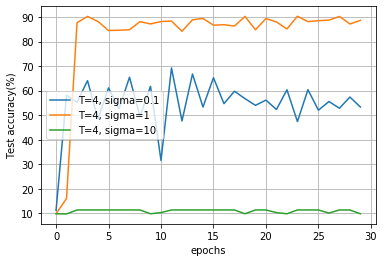

In [83]:
sigma_sel = 0

T_array = np.array([2,4]) # m is the number of received result @ master

sigma_array = np.array([0.1, 1, 10])

plot_acc_v4 = acc_test_arr_v4

print(plot_acc_v4.shape)

# if alloc_idx == 0:
#     Noise_Alloc = [0,1,2,3]
# elif alloc_idx == 1:
#     Noise_Alloc = [0,3,6,9]
# elif alloc_idx == 2:
#     Noise_Alloc = [1,3,5,8]
# elif alloc_idx == 3:
#     Noise_Alloc = [1,3,6,8]

# plt.plot(plot_acc_v3[0,sigma_sel,0,:],label='[0,1,2,3]')
plt.plot(plot_acc_v4[1,0,0,:],label='T=4, sigma=0.1')
plt.plot(plot_acc_v4[1,1,0,:],label='T=4, sigma=1')
plt.plot(plot_acc_v4[1,2,0,:],label='T=4, sigma=10')
# plt.plot(plot_acc_v3[2,sigma_sel,0,:],label='[1,3,5,8]')
# plt.plot(plot_acc_v4[3,1,0,:],label='Case 2: [1,3,6,8]')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [84]:
N = 15
K = 6
T = 4
sigma = 0.1

Noise_Alloc = [0,3,6,9]


X_tilde_case3,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde_case3,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)


@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 



Encoded images & labels


<Figure size 432x288 with 0 Axes>

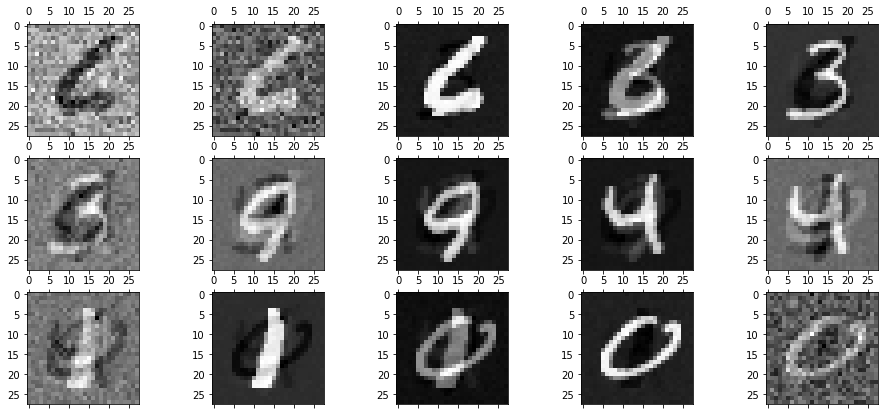

In [85]:
print("Encoded images & labels")
# print(X_tilde.shape)
# print(y_tilde.shape)
encoded_images = X_tilde_case3[:,index_num,:]
encoded_labels = y_tilde_case3[:,index_num,:]
# print(encoded_images.shape)
np.set_printoptions(precision=3)

# for i in range(encoded_images.shape[0]):
#     print('label=', encoded_labels[i,:])
#     pixels = encoded_images[i,:].reshape((28, 28))
#     plt.imshow(pixels, cmap='gray')
#     plt.show()

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

In [26]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

# training
loss_train_arr = []
loss_test_arr = []
acc_test_arr = []
net_best = None
best_loss = None

N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
T_array = np.array([4,6]) # m is the number of received result @ master

sigma_array = np.array([0.1, 1, 5, 10, 15, 20])

loss_test_arr_v4 = np.empty((len(T_array),len(sigma_array),N_trials,N_epochs))
acc_test_arr_v4  = np.empty((len(T_array),len(sigma_array),N_trials,N_epochs))

for T_idx in range(len(T_array)):
    
    m = N # m is the number of received result @ master
    
    T = T_array[T_idx]
    
    if T == 0:
        Noise_Alloc = []
    elif T == 1:
        Noise_Alloc = [0]
    elif T == 2:
        Noise_Alloc = [0,2]
    elif T == 3:
        Noise_Alloc = [0,2,4]
    elif T == 4:
#         Noise_Alloc = [0,3,6,9]
        Noise_Alloc = [1,3,5,7]
    elif T == 5:
        Noise_Alloc = [1,3,5,7,9]
    elif T == 6:
        Noise_Alloc = [1,3,5,7,9,11]
    elif T == 7:
        Noise_Alloc = [1,3,5,7,9,11,12] # np.random.choice(range(K+T), T, replace=False)
    elif T == 8:
        Noise_Alloc = [0,2,4,6,8,9,11,13] # np.random.choice(range(K+T), T, replace=False)
    elif T == 9:
        Noise_Alloc = [0,2,4,6,8,10,12,13,14] # np.random.choice(range(K+T), T, replace=False)
    elif T == 10:
        Noise_Alloc = [0,2,4,6,8,10,12,13,14,15] # np.random.choice(range(K+T), T, replace=False)
    elif T == 11:
        Noise_Alloc = [0,2,4,6,8,10,12,13,14,15,16] # np.random.choice(range(K+T), T, replace=False)
    else:
        Noise_Alloc = np.random.choice(range(K+T), T, replace=False)
        
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)
            
    j_array = np.array(range(K+T))
    # print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
    
    for sigma_idx in range(len(sigma_array)):
        
        sigma = sigma_array[sigma_idx]
        
        _Noise_label = np.ones((10000*T,10)) * 0.1
    
        X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        for trial_idx in range(N_trials):
            print('(T,sigma=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)

                coded_net = BACC_Enc_Model_withNoise(net_glob.cuda(), N, K, T, 0.01, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v4[T_idx][sigma_idx][trial_idx][iter] = acc_test
                loss_test_arr_v4[T_idx][sigma_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

(T,sigma= 4 0.1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2955 
Accuracy: 1135/10000 (11.35%)

Round   1, Average loss 2.295 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.0336 
Accuracy: 9446/10000 (94.46%)

Round   2, Average loss 2.034 Test accuracy 94.460
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.5552 
Accuracy: 9546/10000 (95.46%)

Round   3, Average loss 1.555 Test accuracy 95.460
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.3735 
Accuracy: 9554/10000 (95.54%)

Round   4, Average loss 1.373 Test accuracy 95.540
sele


Test set: Average loss: 1.5246 
Accuracy: 9491/10000 (94.91%)

Round  15, Average loss 1.525 Test accuracy 94.910
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.5114 
Accuracy: 9527/10000 (95.27%)

Round  16, Average loss 1.511 Test accuracy 95.270
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.6423 
Accuracy: 9521/10000 (95.21%)

Round  17, Average loss 1.642 Test accuracy 95.210
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.2359 
Accuracy: 9552/10000 (95.52%)

Round  18, Average loss 1.236 Test accuracy 95.520
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.3520 
Accuracy: 9562/10000 (95.62%)

Round  19, Average loss 1.352 Test accuracy 95.620
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.2959 
Accuracy: 9516/10000 (95.16%)

Round  20, Average loss 1.296 Test accuracy 95


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1010/10000 (10.10%)

Round   1, Average loss 2.303 Test accuracy 10.100
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3025 
Accuracy: 1010/10000 (10.10%)

Round   2, Average loss 2.302 Test accuracy 10.100
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3020 
Accuracy: 1135/10000 (11.35%)

Round   3, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3020 
Accuracy: 1135/10000 (11.35%)

Round   4, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3018 
Accuracy: 1135/10000 (11.35%)

Round   5, Average loss 2.302 Test accuracy 11.35


Test set: Average loss: 2.3023 
Accuracy: 1028/10000 (10.28%)

Round  16, Average loss 2.302 Test accuracy 10.280
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3015 
Accuracy: 1142/10000 (11.42%)

Round  17, Average loss 2.302 Test accuracy 11.420
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2970 
Accuracy: 1321/10000 (13.21%)

Round  18, Average loss 2.297 Test accuracy 13.210
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2943 
Accuracy: 2898/10000 (28.98%)

Round  19, Average loss 2.294 Test accuracy 28.980
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2473 
Accuracy: 6483/10000 (64.83%)

Round  20, Average loss 2.247 Test accuracy 64.830
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1842 
Accuracy: 7834/10000 (78.34%)

Round  21, Average loss 2.184 Test accuracy 78


Test set: Average loss: 1.8305 
Accuracy: 8421/10000 (84.21%)

Round   1, Average loss 1.831 Test accuracy 84.210
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2306 
Accuracy: 9463/10000 (94.63%)

Round   2, Average loss 0.231 Test accuracy 94.630
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1764 
Accuracy: 9478/10000 (94.78%)

Round   3, Average loss 0.176 Test accuracy 94.780
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1751 
Accuracy: 9484/10000 (94.84%)

Round   4, Average loss 0.175 Test accuracy 94.840
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1657 
Accuracy: 9520/10000 (95.20%)

Round   5, Average loss 0.166 Test accuracy 95.200
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1681 
Accuracy: 9499/10000 (94.99%)

Round   6, Average loss 0.168 Test accuracy 94


Test set: Average loss: 0.2008 
Accuracy: 9443/10000 (94.43%)

Round  17, Average loss 0.201 Test accuracy 94.430
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1935 
Accuracy: 9479/10000 (94.79%)

Round  18, Average loss 0.193 Test accuracy 94.790
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1839 
Accuracy: 9499/10000 (94.99%)

Round  19, Average loss 0.184 Test accuracy 94.990
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1941 
Accuracy: 9492/10000 (94.92%)

Round  20, Average loss 0.194 Test accuracy 94.920
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1929 
Accuracy: 9494/10000 (94.94%)

Round  21, Average loss 0.193 Test accuracy 94.940
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2002 
Accuracy: 9491/10000 (94.91%)

Round  22, Average loss 0.200 Test accuracy 94


Test set: Average loss: 2.2911 
Accuracy: 3429/10000 (34.29%)

Round   2, Average loss 2.291 Test accuracy 34.290
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2363 
Accuracy: 7759/10000 (77.59%)

Round   3, Average loss 2.236 Test accuracy 77.590
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1582 
Accuracy: 8355/10000 (83.55%)

Round   4, Average loss 2.158 Test accuracy 83.550
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1320 
Accuracy: 8488/10000 (84.88%)

Round   5, Average loss 2.132 Test accuracy 84.880
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1330 
Accuracy: 8176/10000 (81.76%)

Round   6, Average loss 2.133 Test accuracy 81.760
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.0392 
Accuracy: 8231/10000 (82.31%)

Round   7, Average loss 2.039 Test accuracy 82


Test set: Average loss: 2.2253 
Accuracy: 7707/10000 (77.07%)

Round  18, Average loss 2.225 Test accuracy 77.070
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1730 
Accuracy: 8402/10000 (84.02%)

Round  19, Average loss 2.173 Test accuracy 84.020
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2060 
Accuracy: 7241/10000 (72.41%)

Round  20, Average loss 2.206 Test accuracy 72.410
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1534 
Accuracy: 8266/10000 (82.66%)

Round  21, Average loss 2.153 Test accuracy 82.660
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2550 
Accuracy: 5491/10000 (54.91%)

Round  22, Average loss 2.255 Test accuracy 54.910
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1855 
Accuracy: 8626/10000 (86.26%)

Round  23, Average loss 2.186 Test accuracy 86

(2, 6, 1, 30)


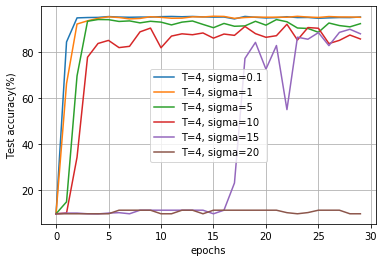

In [28]:
sigma_sel = 0

T_array = np.array([2,4]) # m is the number of received result @ master

sigma_array = np.array([0.1, 1, 5, 10, 20, 50])
sigma_array = np.array([0.1, 1, 5, 10, 15])
plot_acc_v5 = acc_test_arr_v4

print(plot_acc_v5.shape)

# if alloc_idx == 0:
#     Noise_Alloc = [0,1,2,3]
# elif alloc_idx == 1:
#     Noise_Alloc = [0,3,6,9]
# elif alloc_idx == 2:
#     Noise_Alloc = [1,3,5,8]
# elif alloc_idx == 3:
#     Noise_Alloc = [1,3,6,8]

# plt.plot(plot_acc_v3[0,sigma_sel,0,:],label='[0,1,2,3]')
plt.plot(plot_acc_v5[1,0,0,:],label='T=4, sigma=0.1')
plt.plot(plot_acc_v5[1,1,0,:],label='T=4, sigma=1')
plt.plot(plot_acc_v5[1,2,0,:],label='T=4, sigma=5')
plt.plot(plot_acc_v5[1,3,0,:],label='T=4, sigma=10')
plt.plot(plot_acc_v5[1,4,0,:],label='T=4, sigma=15')
plt.plot(plot_acc_v5[1,5,0,:],label='T=4, sigma=20')

# plt.plot(plot_acc_v5[2,0,0,:],label='T=6, sigma=0.1')
# plt.plot(plot_acc_v5[2,1,0,:],label='T=6, sigma=1')
# plt.plot(plot_acc_v5[2,2,0,:],label='T=6, sigma=5')
# plt.plot(plot_acc_v5[2,3,0,:],label='T=6, sigma=10')
# plt.plot(plot_acc_v5[2,4,0,:],label='T=6, sigma=20')
# plt.plot(plot_acc_v3[2,sigma_sel,0,:],label='[1,3,5,8]')
# plt.plot(plot_acc_v4[3,1,0,:],label='Case 2: [1,3,6,8]')
# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [24]:
N = 15
K = 6
T = 4
sigma = 10

# Noise_Alloc = [1,3,5,7]
Noise_Alloc = [0,3,6,9]

X_tilde_case3,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde_case3,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)


@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 



Encoded images & labels


<Figure size 432x288 with 0 Axes>

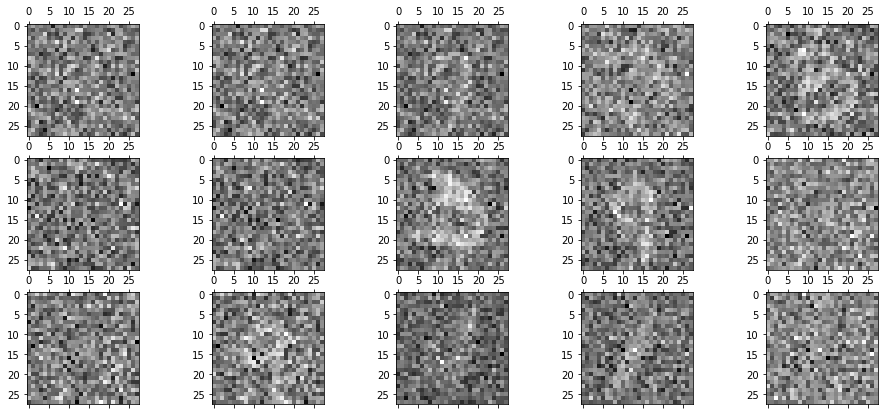

In [25]:
index_num = 3

print("Encoded images & labels")
# print(X_tilde.shape)
# print(y_tilde.shape)
encoded_images = X_tilde_case3[:,index_num,:]
encoded_labels = y_tilde_case3[:,index_num,:]
# print(encoded_images.shape)
np.set_printoptions(precision=3)

# for i in range(encoded_images.shape[0]):
#     print('label=', encoded_labels[i,:])
#     pixels = encoded_images[i,:].reshape((28, 28))
#     plt.imshow(pixels, cmap='gray')
#     plt.show()

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()